In [1]:
!pip install jaxtyping equinox

In [2]:
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

import equinox as eqx

In [3]:
# Hyperparameters

BATCH_SIZE = 64
LEARNING_RATE = 3e-4
STEPS = 300
PRINT_EVERY = 10
SEED = 5678

key = jax.random.PRNGKey(SEED)

In [4]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.CIFAR10(
    "CIFAR10",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.CIFAR10(
    "CIFAR10",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import pandas as pd
data  = [(x.numpy()[0], y) for x, y in iter(train_dataset)]
df    = pd.DataFrame(data, columns=['features', 'labels'])
df

,features,labels
0,"[[-0.5372549, -0.6627451, -0.60784316, -0.4666...",6
1,"[[0.20784318, -0.011764705, -0.17647058, -0.19...",9
2,"[[1.0, 0.9843137, 0.9843137, 0.9843137, 0.9843...",9
3,"[[-0.78039217, -0.70980394, -0.7019608, -0.670...",4
4,"[[0.33333337, 0.3176471, 0.38823533, 0.4352941...",1
...,...,...
49995,"[[0.13725495, 0.18431377, 0.22352946, 0.215686...",2
49996,"[[1.0, 0.99215686, 1.0, 0.99215686, 0.99215686...",6
49997,"[[-0.7254902, -0.6862745, -0.67058825, -0.6941...",9
49998,"[[0.48235297, 0.45882356, 0.45098042, 0.443137...",1


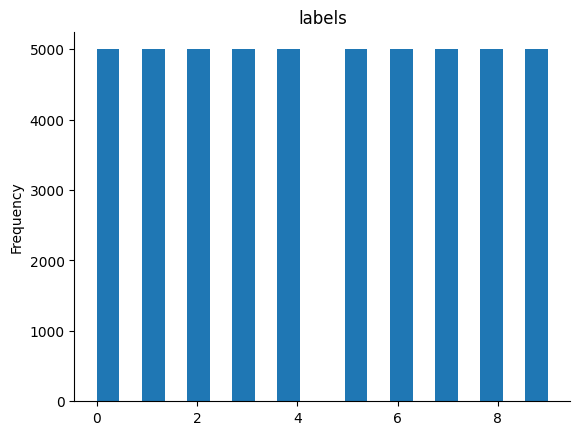

In [6]:
from matplotlib import pyplot as plt
df['labels'].plot(kind='hist', bins=20, title='labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
# Checking our data a bit (by now, everyone knows what the MNIST dataset looks like)
dummy_x, dummy_y = next(iter(trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # 64x1x28x28
print(dummy_y.shape)  # 64
print(dummy_y)

(64, 3, 32, 32)
(64,)
[6 8 0 8 7 4 0 1 9 3 4 8 3 6 0 4 7 2 0 1 6 1 0 6 1 6 2 0 7 6 5 8 8 6 3 3 8
 1 1 6 9 3 3 0 6 1 2 5 3 5 5 9 3 2 3 6 3 3 9 3 3 5 4 0]


In [8]:
import torch
class CNN(eqx.Module):
    layers: list

    def __init__(self, key):
        keys = jax.random.split(key, 5)
        # Standard CNN setup: convolutional layer, followed by flattening,
        # with a small MLP on top.
        self.layers = [
            eqx.nn.Conv2d(3, 16, kernel_size=4, key=keys[0]),
            eqx.nn.MaxPool2d(kernel_size=2),
            jax.nn.relu,
            eqx.nn.Conv2d(16, 32, kernel_size=4, key=keys[1]),
            eqx.nn.MaxPool2d(kernel_size=2),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(18432, 512, key=keys[2]),
            # eqx.nn.BatchNorm(512),
            jax.nn.sigmoid,
            eqx.nn.Linear(512, 64, key=keys[3]),
            # eqx.nn.BatchNorm(64),
            jax.nn.relu,
            eqx.nn.Linear(64, 10, key=keys[4]),
            # eqx.nn.BatchNorm(10),
            jax.nn.log_softmax,
        ]

    def __call__(self, x: Float[Array, "1 32 32"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        return x


key, subkey = jax.random.split(key, 2)
model = CNN(subkey)

In [9]:
def loss(
    model: CNN, x: Float[Array, "batch 3 32 32"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    # Our input has the shape (BATCH_SIZE, 1, 28, 28), but our model operations on
    # a single input input image of shape (1, 28, 28).
    #
    # Therefore, we have to use jax.vmap, which in this case maps our model over the
    # leading (batch) axis.
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y)


def cross_entropy(
    y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"]
) -> Float[Array, ""]:
    # y are the true targets, and should be integers 0-9.
    # pred_y are the log-softmax'd predictions.
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)


# Example loss
loss_value = loss(model, dummy_x, dummy_y)
print(loss_value.shape)  # scalar loss
# Example inference
output = jax.vmap(model)(dummy_x)
print(output.shape)  # batch of predictions

()
(64, 10)


In [10]:
# This will work!
params, static = eqx.partition(model, eqx.is_array)


def loss2(params, static, x, y):
    model = eqx.combine(params, static)
    return loss(model, x, y)


loss_value, grads = jax.value_and_grad(loss2)(params, static, dummy_x, dummy_y)
print(loss_value)

2.31608


In [11]:
# This will work too!
value, grads = eqx.filter_value_and_grad(loss)(model, dummy_x, dummy_y)
print(value)

2.31608


In [12]:
loss = eqx.filter_jit(loss)  # JIT our loss function from earlier!


@eqx.filter_jit
def compute_accuracy(
    model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    """This function takes as input the current model
    and computes the average accuracy on a batch.
    """
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)

In [13]:
def evaluate(model: CNN, testloader: torch.utils.data.DataLoader):
    """This function evaluates the model on the test dataset,
    computing both the average loss and the average accuracy.
    """
    avg_loss = 0
    avg_acc = 0
    for x, y in testloader:
        x = x.numpy()
        y = y.numpy()
        # Note that all the JAX operations happen inside `loss` and `compute_accuracy`,
        # and both have JIT wrappers, so this is fast.
        avg_loss += loss(model, x, y)
        avg_acc += compute_accuracy(model, x, y)
    return avg_loss / len(testloader), avg_acc / len(testloader)

In [14]:
evaluate(model, testloader)

(Array(2.3068202, dtype=float32), Array(0.09992038, dtype=float32))

In [15]:
optim = optax.adamw(LEARNING_RATE)

In [16]:
from dataclasses import dataclass

@dataclass
class RunData:
    step: int
    train_loss: float
    test_loss: float
    test_accuracy: float

def train(
    model: CNN,
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    steps: int,
    print_every: int,
) -> CNN:
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model: CNN,
        opt_state: PyTree,
        x: Float[Array, "batch 1 28 28"],
        y: Int[Array, " batch"],
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    # Loop over our training dataset as many times as we need.
    def infinite_trainloader():
        while True:
            yield from trainloader

    run_data = []
    for step, (x, y) in zip(range(steps), infinite_trainloader()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x = x.numpy()
        y = y.numpy()
        model, opt_state, train_loss = make_step(model, opt_state, x, y)

        if (step % print_every) == 0 or (step == steps - 1):
            test_loss, test_accuracy = evaluate(model, testloader)
            print(
                f"{step=}, train_loss={train_loss.item()}, "
                f"test_loss={test_loss.item()}, test_accuracy={test_accuracy.item()}"
            )
            run_data +=  [RunData(step=step,
                                  train_loss=train_loss.item(),
                                  test_loss=test_loss.item(),
                                  test_accuracy=test_accuracy.item())]


    return model, run_data

In [17]:
model, run_data = train(model, trainloader, testloader, optim, STEPS, PRINT_EVERY)

step=230, train_loss=1.5627658367156982, test_loss=1.5485100746154785, test_accuracy=0.431329607963562
step=240, train_loss=1.8047233819961548, test_loss=1.5011097192764282, test_accuracy=0.46516719460487366
step=250, train_loss=1.7322763204574585, test_loss=1.4762375354766846, test_accuracy=0.47143709659576416
step=260, train_loss=1.3504961729049683, test_loss=1.477417230606079, test_accuracy=0.4773089289665222
step=270, train_loss=1.5455098152160645, test_loss=1.469976544380188, test_accuracy=0.4675557315349579
step=280, train_loss=1.4072723388671875, test_loss=1.4552741050720215, test_accuracy=0.48069268465042114
step=290, train_loss=1.333311915397644, test_loss=1.434658169746399, test_accuracy=0.4844745099544525
step=299, train_loss=1.50449800491333, test_loss=1.4245104789733887, test_accuracy=0.49104300141334534


In [18]:
# jax.grad(model)(x)
eqx.filter_value_and_grad(loss)(model, dummy_x, dummy_y)

(Array(1.4141067, dtype=float32),
 CNN(
   layers=[
     Conv2d(
       num_spatial_dims=2,
       weight=f32[16,3,4,4],
       bias=f32[16,1,1],
       in_channels=3,
       out_channels=16,
       kernel_size=(4, 4),
       stride=(1, 1),
       padding=((0, 0), (0, 0)),
       dilation=(1, 1),
       groups=1,
       use_bias=True
     ),
     MaxPool2d(
       init=None,
       operation=None,
       num_spatial_dims=2,
       kernel_size=(2, 2),
       stride=(1, 1),
       padding=((0, 0), (0, 0)),
       use_ceil=False
     ),
     None,
     Conv2d(
       num_spatial_dims=2,
       weight=f32[32,16,4,4],
       bias=f32[32,1,1],
       in_channels=16,
       out_channels=32,
       kernel_size=(4, 4),
       stride=(1, 1),
       padding=((0, 0), (0, 0)),
       dilation=(1, 1),
       groups=1,
       use_bias=True
     ),
     MaxPool2d(
       init=None,
       operation=None,
       num_spatial_dims=2,
       kernel_size=(2, 2),
       stride=(1, 1),
       padding=((0, 0)

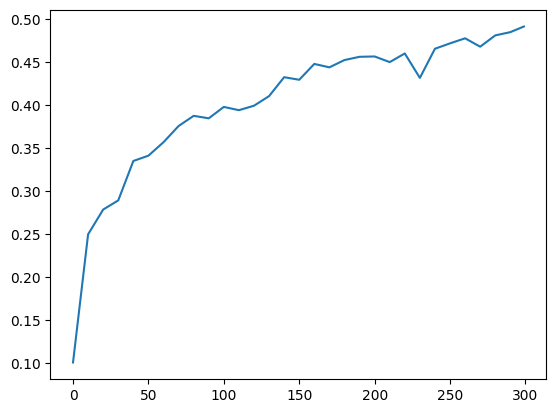

In [19]:
import matplotlib.pyplot as plt
steps         = [x.step for x in run_data]
test_accuracy = [x.test_accuracy for x in run_data]

plt.plot(steps, test_accuracy)